This is early experimenting with importing real world data, playing around with our existing code, and determining how/if h5py (HDF5) file format will be appropriate for our needs.

In [170]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt

from ramannoodles import spectrafit

In [171]:
CO_data = pd.read_excel('../../Baseline Subtracted Data/CarbonMonoxide_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
Me_data = pd.read_excel('../../Baseline Subtracted Data/Methane_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
H_data = pd.read_excel('../../Baseline Subtracted Data/Hydrogen_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
FA_data = pd.read_excel('../../FormicAcid_3percentconc_400C_5s_00000.xlsx',
                        header=None, names=('x', 'y'))

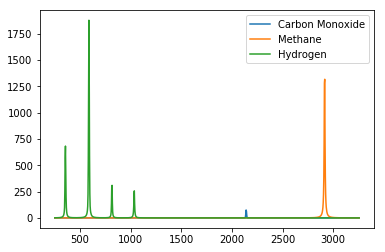

In [172]:
plt.plot(CO_data['x'], CO_data['y'], label='Carbon Monoxide')
plt.plot(Me_data['x'], Me_data['y'], label='Methane')
plt.plot(H_data['x'], H_data['y'], label='Hydrogen')
plt.legend()

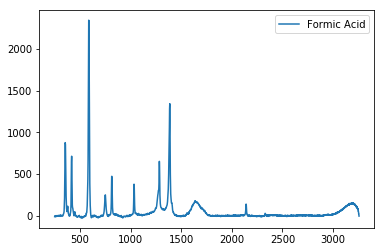

In [173]:
plt.plot(FA_data['x'], FA_data['y'], label='Formic Acid')
plt.legend()

In [181]:
data = H_data

In [182]:
peaks, peak_list1 = spectrafit.peak_detect(data['x'].values, data['y'].values, height=10, prominence=20)
peaks

[(355.6504104104104, 682.2117661687759),
 (587.3333133133133, 1877.5935473330196),
 (816.0073473473473, 309.10228007461126),
 (1035.6547747747748, 256.8016351111647)]

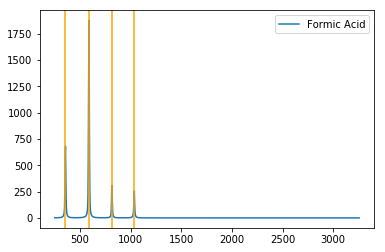

In [183]:
plt.plot(data['x'], data['y'], label='Formic Acid')
for i in peak_list1[0]:
    plt.axvline(x=data['x'][i], color='orange')
plt.legend()

In [184]:
from lmfit.models import LorentzianModel
from lmfit.models import GaussianModel
from lmfit.models import VoigtModel

In [185]:
peak_list = []
for i, _ in enumerate(peaks):
    prefix = 'p{}_'.format(i+1)
    peak = VoigtModel(prefix=prefix)
    if i == 0:
        pars = peak.make_params()
    else:
        pars.update(peak.make_params())
    pars[prefix+'center'].set(peaks[i][0], vary=False,
                              min=(peaks[i][0]-10), max=(peaks[i][0]+10))
    pars[prefix+'height'].set(peaks[i][1], vary=False)
    pars[prefix+'sigma'].set(min=0, max=500)
    pars[prefix+'amplitude'].set(min=0)
    peak_list.append(peak)
    if i == 0:
        mod = peak_list[i]
    else:
        mod = mod + peak_list[i]

In [186]:
out = mod.fit(data['y'], pars, x=data['x'])
print(out.fit_report())

[[Model]]
    (((Model(voigt, prefix='p1_') + Model(voigt, prefix='p2_')) + Model(voigt, prefix='p3_')) + Model(voigt, prefix='p4_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 101
    # data points      = 1000
    # variables        = 8
    chi-square         = 38031.6423
    reduced chi-square = 38.3383491
    Akaike info crit   = 3654.41851
    Bayesian info crit = 3693.68055
[[Variables]]
    p1_sigma:      2.55432507 +/- 0.02595252 (1.02%) (init = 1)
    p1_center:     355.6504 (fixed)
    p1_amplitude:  8322.54023 +/- 65.0515766 (0.78%) (init = 1)
    p1_gamma:      2.55432507 +/- 0.02595252 (1.02%) == 'p1_sigma'
    p1_fwhm:       9.19886698 +/- 0.05683400 (0.62%) == '1.0692*p1_gamma+sqrt(0.8664*p1_gamma**2+5.545083*p1_sigma**2)'
    p1_height:     682.2118 (fixed)
    p2_sigma:      2.41900768 +/- 0.00912416 (0.38%) (init = 1)
    p2_center:     587.3333 (fixed)
    p2_amplitude:  21761.3984 +/- 63.2511897 (0.29%) (init = 1)
    p2_gamma:      

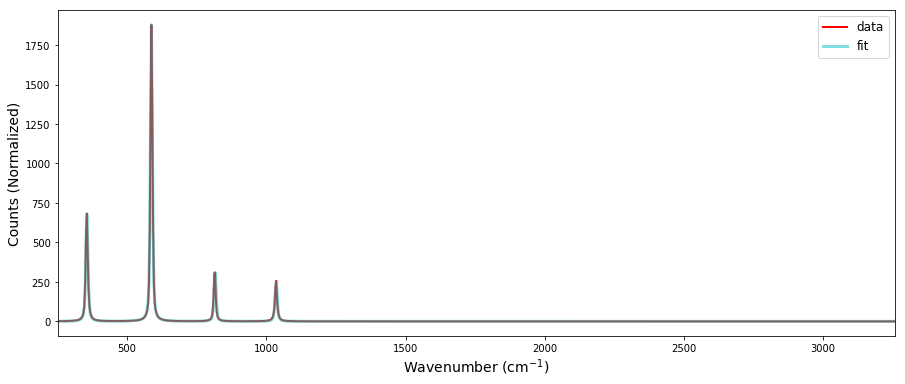

In [187]:
spectrafit.plot_fit(data['x'].values, data['y'].values, out, )